# Calculating the Return on Investement for Single-Family Home Sales
For any investment, we want to know how much we can make from the investment. Especially when intrest rates are high, investing in index funds may generate good ROI with low risk. To know if our investment is worth it, we need the following inputs. 

* **Purchase Cost** this is how much we're paying upfront for the properties we're buying.
* **Renovation Cost** this is how much we're spending on upgrades.
* **Holding Cost** while we own the property, how much is it costing us in terms of taxes, utilites, insurance, and upkeep. We will assume a fixed amount per property.
* **Financing Cost** we're making mortage payments while we've the property. How much interest is it costing us?
* **Selling Cost** typically, we would have an broker who takes a commission plus closing costs. Typically, this sets around 5-6% of the sale price.
* **Final Sale Price** how much we're selling each property for.

To acquire those inputs, we will look into the data Zillow provides. We won't find all the data such holding and selling costs, so we will use estimates or use other data sets to acquire those inputs. 

First, we need to build our investment portfolio and we start by identifying high growth markets. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import util
%matplotlib inline     
sns.set(color_codes=True)

## Identifying High Growth Markets
First, we need to identify high growth market where we can have high return on investment. Zillow Home Value Index is a home price estimation from Zillow that we can use to identify high growth markets. So we will use the `ZHVI Single-Family Homes Time Series ($)` dataset. Zillow provides a forecast dataset, but the dataset covers all home types, so we will have to build our own based on the investor intrest.  

First, let's load the data and inspect some top and bottom rows.

In [2]:
# Load the Zillow dataset
df = pd.read_csv('../data/sfh_ts.csv')
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,1,"New York, NY",msa,NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,2,"Los Angeles, CA",msa,CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,3,"Chicago, IL",msa,IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,4,"Dallas, TX",msa,TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [3]:
df.tail()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
890,753929,935,"Zapata, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,125505.480365,124620.859170,124703.453283,126217.346418,127940.190271,129029.544547,129216.203575,128841.856015,128169.963134,127248.665154
891,394743,936,"Ketchikan, AK",msa,AK,NaN,NaN,NaN,NaN,NaN,...,411724.194103,411668.716287,413385.593811,415037.934548,416247.744981,416235.514828,415323.647956,415325.998281,416842.773776,419086.682223
892,753874,937,"Craig, CO",msa,CO,98830.861837,99097.911211,99574.805478,100259.229234,101040.616567,...,285287.949217,285219.875814,285685.290380,286463.285398,287357.918108,287698.710801,288033.677233,288266.115146,289594.833055,291259.120524
893,395188,938,"Vernon, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,91184.718655,91281.020656,91975.182494,92739.898571,93395.868423,93641.985168,93402.487663,92893.101563,91612.695630,90013.700765
894,394767,939,"Lamesa, TX",msa,TX,NaN,NaN,NaN,NaN,NaN,...,88711.311676,87596.741991,87637.262603,87847.018796,88770.521386,90064.663210,91903.350319,93542.740242,94253.311435,94265.128384


From the initial look, we can quickly spot the following
* The data is optimized for size, so each region has a single row and each estimation is a value in a date column.
* We've some null values for older dates in some regions.

In [4]:
# Let's confirm our assumption about "each region is a single row"
df[df.duplicated(subset='RegionID', keep=False)]

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31


In [5]:
# Let's drop any fields we're not going to use. We're keeping RegionID because it's safer to use than RegionName
# which contains white space. Additionally, we will use RegionID to interact with other datasets from Zillow
# we also should keep state names in case we need to deal with aggregate date at state-level
single_home_values = df.drop(columns=['SizeRank', 'RegionType'])
single_home_values.head()

,RegionID,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,United States,NaN,121531.336651,121738.651072,121995.876446,122548.308184,123184.186238,123865.680213,124586.279073,...,350593.674816,351419.563807,352981.682891,354901.213108,356405.219291,357054.866170,357269.495250,357556.470130,358047.728564,358695.400157
1,394913,"New York, NY",NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,"Los Angeles, CA",CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,"Chicago, IL",IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,"Dallas, TX",TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639


In [6]:
# We can note that we've an entry for the United States which we don't need, so let's also drop this row.
single_home_values.drop(0, inplace=True)
single_home_values.head()

,RegionID,RegionName,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
1,394913,"New York, NY",NY,215526.347853,216437.299774,217353.388393,219206.206623,221115.123983,223259.025429,225613.438183,...,653024.167946,657325.710093,662976.463941,669457.862304,674379.010648,677580.634957,680209.743078,683834.502366,687956.181425,691747.775297
2,753899,"Los Angeles, CA",CA,228840.318549,229713.653329,230850.552728,233116.339880,235575.321729,238017.327535,240515.010731,...,961240.278183,958067.128774,956942.083361,960982.286878,967579.982979,972048.452546,976772.555536,982347.195293,989199.485026,994897.480686
3,394463,"Chicago, IL",IL,156308.333980,156460.092041,156739.556227,157434.724023,158265.478146,159199.059474,160194.910072,...,323407.920786,325014.621277,327666.811355,330756.679881,333074.201792,334422.582458,335234.282077,336199.561203,337340.532590,338506.114351
4,394514,"Dallas, TX",TX,126045.193158,126100.940737,126169.731762,126344.177104,126568.833701,126796.407950,127030.425355,...,371215.184232,371698.224857,372852.439583,373826.243574,373978.341627,373322.949324,372396.923106,371759.173084,371580.012878,371494.296639
5,394692,"Houston, TX",TX,122566.394660,122586.615487,122498.107793,122552.473556,122601.663389,122792.886927,122963.068045,...,306485.894827,306879.944577,307878.534350,308913.023118,309454.105049,309335.478400,308972.502773,308770.188744,308740.930953,308583.122732


**Transforming the Data**
Now, let's transform the data to make it possible for calculating month-over-month growth rate. While we're doing this, we will drop home values which is NaN

In [7]:
# Reshape the data. Convert columns to rows using melt()
single_home_values_melted = single_home_values.melt(id_vars=['RegionID', 'RegionName', 'StateName'], 
                    var_name='EestimationDate',
                    value_name='HomeValue')

# Convert 'EestimationDate' to datetime type
single_home_values_melted['EestimationDate'] = pd.to_datetime(single_home_values_melted['EestimationDate'])

# Drop rows where 'HomeValue' is null or zero
single_home_values_final = single_home_values_melted.dropna(subset='HomeValue')

In [8]:
# Verify the cleaning step
print(single_home_values_final.isnull().sum())

RegionID           0
RegionName         0
StateName          0
EestimationDate    0
HomeValue          0
dtype: int64


In [9]:
# Take a look at our transformed table
single_home_values_final.head()

,RegionID,RegionName,StateName,EestimationDate,HomeValue
0,394913,"New York, NY",NY,2000-01-31,215526.347853
1,753899,"Los Angeles, CA",CA,2000-01-31,228840.318549
2,394463,"Chicago, IL",IL,2000-01-31,156308.333980
3,394514,"Dallas, TX",TX,2000-01-31,126045.193158
4,394692,"Houston, TX",TX,2000-01-31,122566.394660


In [10]:
# Ensure date types are accurate
single_home_values_final.dtypes

RegionID                    int64
RegionName                 object
StateName                  object
EestimationDate    datetime64[ns]
HomeValue                 float64
dtype: object

In [11]:
# For simplicity, use the region name as index
single_home_values_final.set_index('RegionName', inplace=True)
single_home_values_final.head()

,RegionID,StateName,EestimationDate,HomeValue
RegionName,,,,
"New York, NY",394913,NY,2000-01-31,215526.347853
"Los Angeles, CA",753899,CA,2000-01-31,228840.318549
"Chicago, IL",394463,IL,2000-01-31,156308.333980
"Dallas, TX",394514,TX,2000-01-31,126045.193158
"Houston, TX",394692,TX,2000-01-31,122566.394660


In [12]:
# Let's calculate our month-over-month change
# Sort the data by RegionID and Date for correct pct_change calculation
single_home_values_final = single_home_values_final.sort_values(by=['RegionID', 'EestimationDate'])

# Calculate the month-over-month change for 'HomeValue'
single_home_values_final['MoM_Change'] = single_home_values_final.groupby('RegionID')['HomeValue'].pct_change() * 100
single_home_values_final.head()

,RegionID,StateName,EestimationDate,HomeValue,MoM_Change
RegionName,,,,,
"Aberdeen, SD",394297,SD,2009-02-28,129498.397203,NaN
"Aberdeen, SD",394297,SD,2009-03-31,129512.232545,0.010684
"Aberdeen, SD",394297,SD,2009-04-30,129314.309011,-0.152822
"Aberdeen, SD",394297,SD,2009-05-31,129201.263533,-0.087419
"Aberdeen, SD",394297,SD,2009-06-30,129003.424531,-0.153125


In [13]:
single_home_values_final = single_home_values_final.dropna(subset=['MoM_Change'])

# Sort by MoM Change (in descending order)
top_25_regions = util.get_top_regions_by_mom_change(single_home_values_final)
display(top_25_regions)

,RegionID,RegionName,MoM_Change
660,395033,"Rockford, IL",0.813178
757,395143,"Syracuse, NY",0.804417
682,395059,"San Jose, CA",0.786331
587,394951,"Oxford, MS",0.764303
91,394397,"Blytheville, AR",0.744494
629,395000,"Pottsville, PA",0.728000
499,394855,"Miami, OK",0.727374
70,394374,"Beckley, WV",0.722711
231,394556,"Edwards, CO",0.716400
310,394643,"Great Bend, KS",0.713209


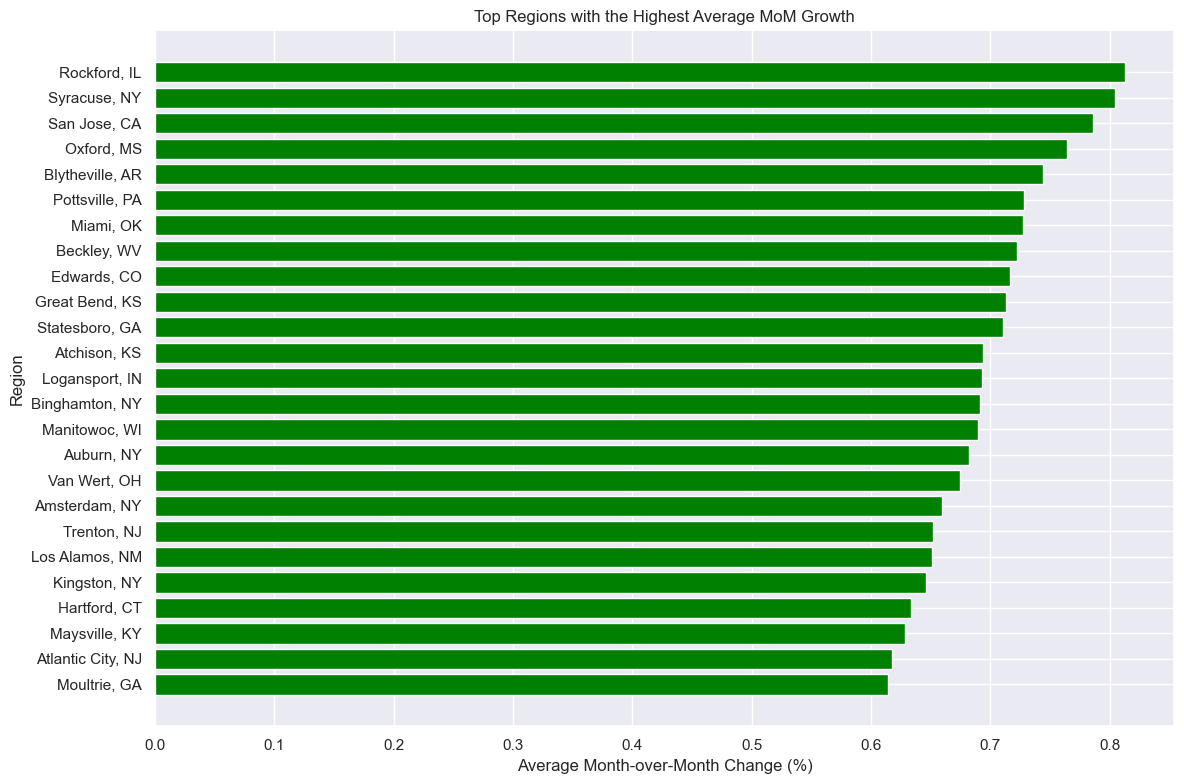

In [14]:
util.plot_top_regions_mom_change(top_25_regions)

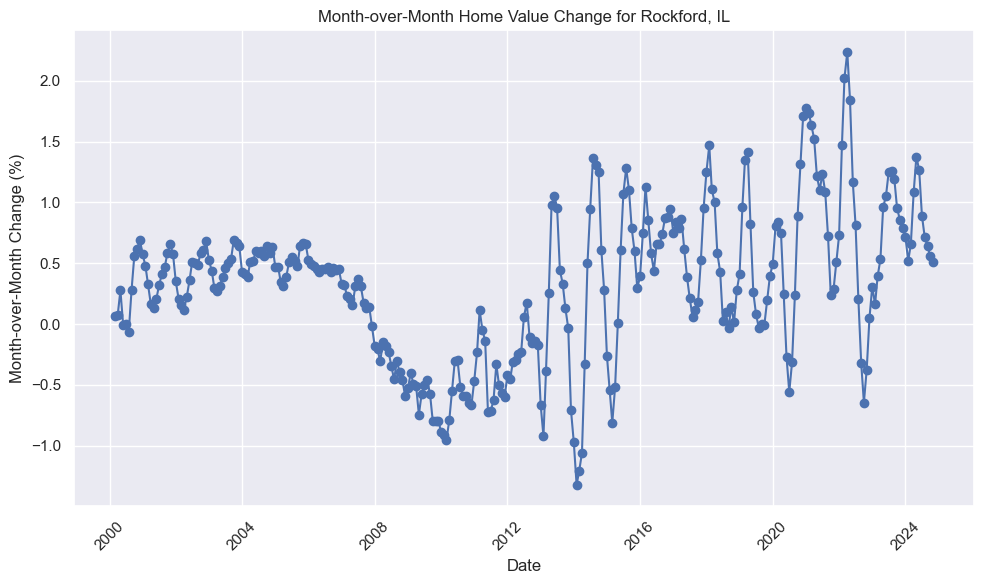

In [15]:
# Show top region entire history of MoM
util.plot_region_mom_change(single_home_values_final[single_home_values_final['RegionID'] == 395033], 'Rockford, IL')

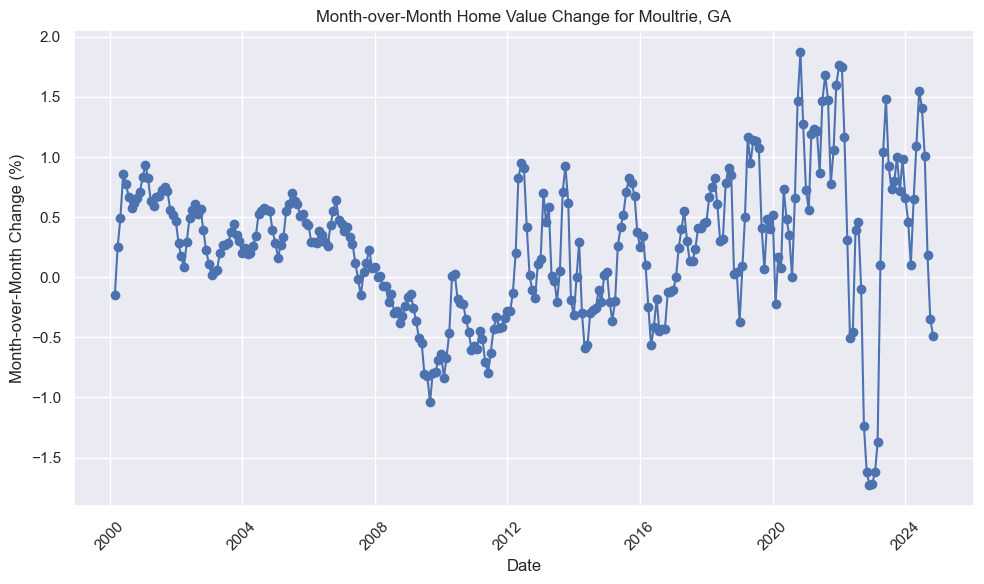

In [16]:
# Show bottom region entire history of MoM
# 394883	Moultrie, GA
util.plot_region_mom_change(single_home_values_final[single_home_values_final['RegionID'] == 394883], 'Moultrie, GA')

## Identifying Holding Period

Holding period is important for calculating many of our ROI parameters. For example, we need to know how long we're holding the unit for to calculate how much financing charges we would incur. Additionally, we need to know the sale date to identify the approximate property sell price. 

Parameters to calculate the holding period:
* **Renovation Time** this is the time we're using to upgrade the property. For our calculation purposes, we will assume 3 months or 90 days for upgrading the property.
* **Days-to-List** after we finish our upgrades, how long will we wait before we list the property for sale. We may hold the unit for some time to meet our forecasted sale price.
* **Days-to-Pending** this is how long the unit is on the market for before a buyer makes an acceptable offer. We will use Zillow dataset to estimate. 
* **Days-to-Close** how many days elapsed since an offer has been accepted till the sale is finalized and legal papers are signed. We will use Zillow dataset to estimate.

In [17]:
mean_days_to_pending = pd.read_csv('../data/Metro_mean_doz_pending_uc_sfrcondo_sm_month.csv')
mean_days_to_pending.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31
0,102001,0,United States,country,NaN,51.0,48.0,45.0,43.0,44.0,...,49.0,52.0,49.0,43.0,39.0,37.0,38.0,41.0,44.0,46.0
1,394913,1,"New York, NY",msa,NY,68.0,65.0,63.0,64.0,66.0,...,68.0,71.0,67.0,58.0,51.0,49.0,49.0,52.0,55.0,58.0
2,753899,2,"Los Angeles, CA",msa,CA,35.0,32.0,31.0,32.0,33.0,...,40.0,41.0,37.0,33.0,30.0,29.0,30.0,33.0,36.0,38.0
3,394463,3,"Chicago, IL",msa,IL,51.0,44.0,40.0,39.0,40.0,...,42.0,43.0,38.0,31.0,26.0,24.0,24.0,25.0,28.0,31.0
4,394514,4,"Dallas, TX",msa,TX,46.0,42.0,38.0,37.0,38.0,...,51.0,52.0,49.0,43.0,39.0,38.0,40.0,45.0,50.0,54.0


In [19]:
# Let's format the data similar to our home value index data
mean_days_to_pending_melted = util.melt_zillow_dataset(mean_days_to_pending, id_fields=['RegionID', 'RegionName',	'StateName'], index_field='RegionName', fields_to_drop=['SizeRank', 'RegionType'], value_col='DaysToPending')
mean_days_to_pending_melted.head()

,RegionID,StateName,Date,DaysToPending
RegionName,,,,
"New York, NY",394913,NY,2018-03-31,68.0
"Los Angeles, CA",753899,CA,2018-03-31,35.0
"Chicago, IL",394463,IL,2018-03-31,51.0
"Dallas, TX",394514,TX,2018-03-31,46.0
"Houston, TX",394692,TX,2018-03-31,49.0


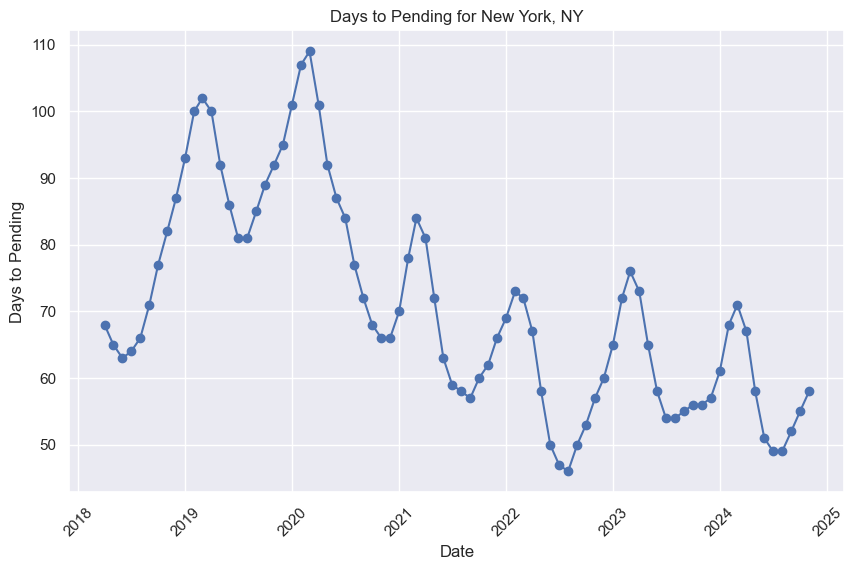

In [23]:
# Filter data for one region (e.g., 'New York, NY')
region_data = mean_days_to_pending_melted[mean_days_to_pending_melted['RegionID'] == 394913]

# Plot the timeline for this region
plt.figure(figsize=(10, 6))
plt.plot(region_data['Date'], region_data['DaysToPending'], marker='o', linestyle='-', color='b')
plt.title('Days to Pending for New York, NY')
plt.xlabel('Date')
plt.ylabel('Days to Pending')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

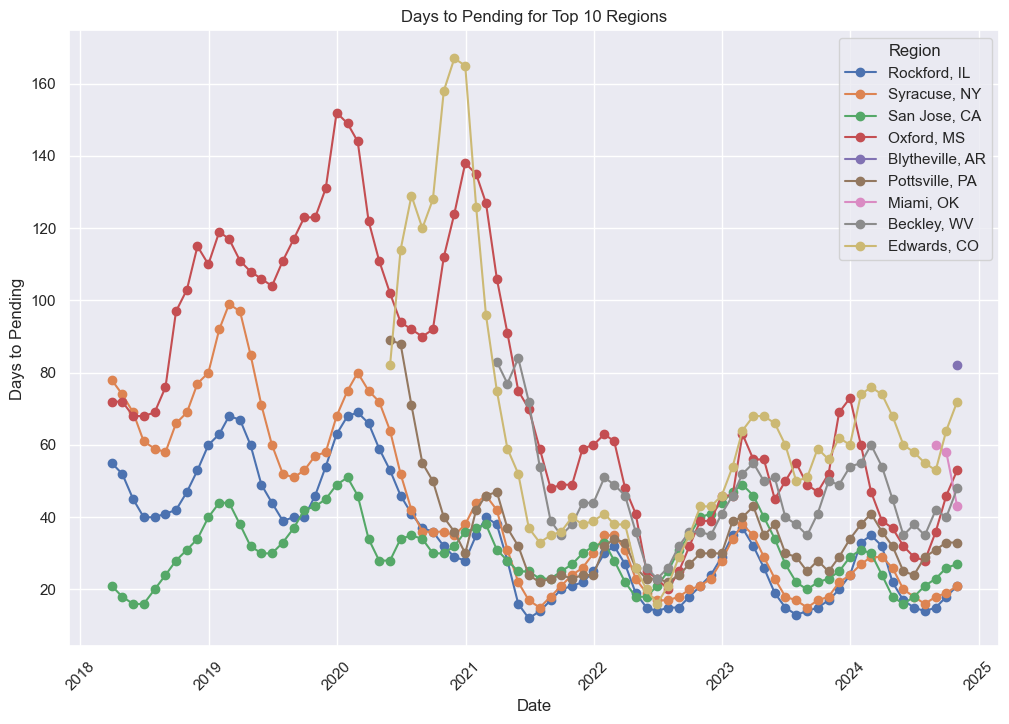

In [39]:
# Trends among our top ten regions
regions_to_plot = top_25_regions.head(10)['RegionID']
multiple_region_data = mean_days_to_pending_melted[mean_days_to_pending_melted['RegionID'].isin(regions_to_plot)].reset_index()

# Plot the timelines for multiple regions
plt.figure(figsize=(12, 8))

for region in regions_to_plot:
    region_data = multiple_region_data[multiple_region_data['RegionID'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['DaysToPending'], marker='o', label=region_data['RegionName'].iloc[0])

plt.title('Days to Pending for Top 10 Regions')
plt.xlabel('Date')
plt.ylabel('Days to Pending')
plt.legend(title='Region')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [40]:
mean_days_to_close = pd.read_csv('../data/Metro_mean_days_to_close_uc_sfrcondo_sm_month.csv')
mean_days_to_close.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,...,2023-12-31,2024-01-31,2024-02-29,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30
0,102001,0,United States,country,NaN,35.0,34.0,34.0,35.0,36.0,...,33.0,34.0,34.0,33.0,32.0,33.0,34.0,34.0,34.0,34.0
1,394913,1,"New York, NY",msa,NY,57.0,53.0,50.0,51.0,53.0,...,53.0,54.0,55.0,54.0,52.0,51.0,53.0,54.0,55.0,55.0
2,753899,2,"Los Angeles, CA",msa,CA,34.0,32.0,33.0,33.0,34.0,...,30.0,31.0,30.0,30.0,29.0,29.0,29.0,29.0,29.0,30.0
3,394463,3,"Chicago, IL",msa,IL,43.0,42.0,42.0,44.0,45.0,...,37.0,38.0,37.0,37.0,36.0,37.0,38.0,38.0,38.0,37.0
4,394514,4,"Dallas, TX",msa,TX,21.0,21.0,21.0,22.0,22.0,...,28.0,28.0,28.0,28.0,28.0,28.0,29.0,29.0,29.0,28.0


In [41]:
mean_days_to_close_melted = util.melt_zillow_dataset(mean_days_to_close, id_fields=['RegionID', 'RegionName',	'StateName'], index_field='RegionName', fields_to_drop=['SizeRank', 'RegionType'], value_col='DaysToClose')
mean_days_to_close_melted.head()

,RegionID,StateName,Date,DaysToClose
RegionName,,,,
"New York, NY",394913,NY,2018-03-31,57.0
"Los Angeles, CA",753899,CA,2018-03-31,34.0
"Chicago, IL",394463,IL,2018-03-31,43.0
"Dallas, TX",394514,TX,2018-03-31,21.0
"Houston, TX",394692,TX,2018-03-31,31.0


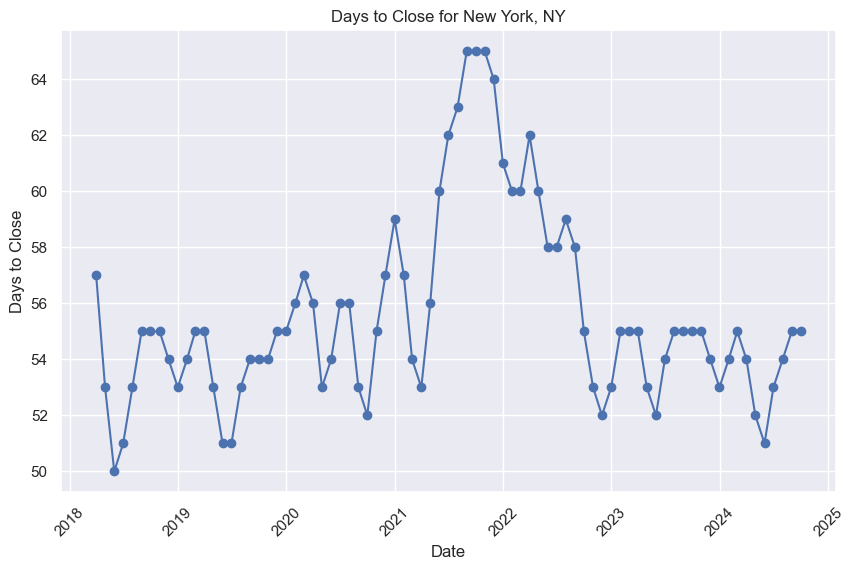

In [44]:
# Filter data for one region (e.g., 'New York, NY')
region_data = mean_days_to_close_melted[mean_days_to_close_melted['RegionID'] == 394913]

# Plot the timeline for this region
plt.figure(figsize=(10, 6))
plt.plot(region_data['Date'], region_data['DaysToClose'], marker='o', linestyle='-', color='b')
plt.title('Days to Close for New York, NY')
plt.xlabel('Date')
plt.ylabel('Days to Close')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

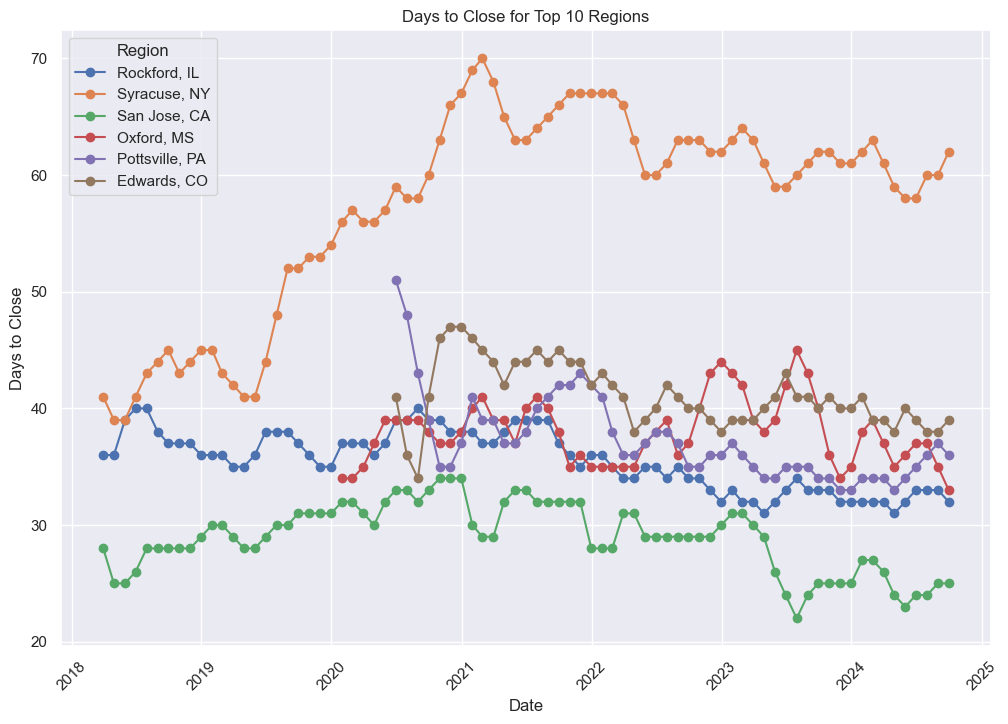

In [45]:
# Trends among our top ten regions
regions_to_plot = top_25_regions.head(10)['RegionID']
multiple_region_data = mean_days_to_close_melted[mean_days_to_close_melted['RegionID'].isin(regions_to_plot)].reset_index()

# Plot the timelines for multiple regions
plt.figure(figsize=(12, 8))

for region in regions_to_plot:
    region_data = multiple_region_data[multiple_region_data['RegionID'] == region]
    if not region_data.empty:
        plt.plot(region_data['Date'], region_data['DaysToClose'], marker='o', label=region_data['RegionName'].iloc[0])

plt.title('Days to Close for Top 10 Regions')
plt.xlabel('Date')
plt.ylabel('Days to Close')
plt.legend(title='Region')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()